# Predicción de Riesgo Crediticio con XGBoost

In [2]:
# Load Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd 
import multiprocessing
import random




from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
import timeit

## Dataset

Leamos el dataset a utilizar.

In [111]:
# Load the dataset 
X = pd.read_excel("/Users/galovalle/Desktop/DP3/processed.xlsx")
X.shape

(3277, 48)

El dataset consta de:

- 3277 **filas** o instancias
- 48 **columnas** o variables.

Veamos su contenido.

In [81]:
X.head()

,bank_branch_clients,loannumber,loanamount,totaldue,termdays,good_bad_flag,referred,realage,TipoInteresAhora,bank_account_Current,...,employment_status_client_Self-Employed,employment_status_client_Student,employment_status_client_Unemployed,employment_status_client_Unknown,number_of_Loans,accumlated_loan_given,accumlated_timediff,time-to-payoff,accumulated_money_won,is_late_for_firstpay
0,0,2,10000,13000.0,30,1,1,48,1.00,0,...,0,0,0,1,1.0,10000.0,3.667000e+12,1.300528e+15,1500.0,0.0
1,0,2,10000,13000.0,30,0,0,36,1.00,0,...,0,0,0,0,1.0,10000.0,3.668000e+12,2.840792e+15,3000.0,1.0
2,0,4,10000,13000.0,30,1,0,35,1.00,0,...,0,0,0,1,3.0,30000.0,1.083500e+13,5.520142e+15,6000.0,1.0
3,0,2,10000,11500.0,15,1,0,30,1.00,0,...,0,0,0,0,1.0,10000.0,3.668000e+12,2.873995e+15,1500.0,1.0
4,0,6,20000,24500.0,30,1,0,31,0.75,0,...,0,0,0,0,5.0,70000.0,1.809800e+13,1.179669e+23,18000.0,0.0


In [70]:
X= X.drop(['Unnamed: 0','customerid'],axis=1)

In [98]:
X.columns

Index(['bank_branch_clients', 'loannumber', 'loanamount', 'totaldue',
       'termdays', 'referred', 'realage', 'TipoInteresAhora',
       'bank_account_Current', 'bank_account_Other', 'bank_account_Savings',
       'level_of_education_clients_Graduate',
       'level_of_education_clients_Post-Graduate',
       'level_of_education_clients_Primary',
       'level_of_education_clients_Secondary',
       'level_of_education_clients_Unknown', 'bank_name_client_Access Bank',
       'bank_name_client_Diamond Bank', 'bank_name_client_EcoBank',
       'bank_name_client_FCMB', 'bank_name_client_Fidelity Bank',
       'bank_name_client_First Bank', 'bank_name_client_GT Bank',
       'bank_name_client_Heritage Bank', 'bank_name_client_Keystone Bank',
       'bank_name_client_Skye Bank', 'bank_name_client_Stanbic IBTC',
       'bank_name_client_Standard Chartered', 'bank_name_client_Sterling Bank',
       'bank_name_client_UBA', 'bank_name_client_Union Bank',
       'bank_name_client_Unity Bank', 

In [83]:
X2=X

In [73]:
X=X.dropna()

In [112]:
X= X.drop(['level_of_education_clients_Unknown', 'bank_name_client_Access Bank',
       'bank_name_client_Diamond Bank', 'bank_name_client_EcoBank',
       'bank_name_client_FCMB', 'bank_name_client_Fidelity Bank',
       'bank_name_client_First Bank', 'bank_name_client_GT Bank',
       'bank_name_client_Heritage Bank', 'bank_name_client_Keystone Bank',
       'bank_name_client_Skye Bank', 'bank_name_client_Stanbic IBTC',
       'bank_name_client_Standard Chartered', 'bank_name_client_Sterling Bank',
       'bank_name_client_UBA', 'bank_name_client_Union Bank',
       'bank_name_client_Unity Bank', 'bank_name_client_Wema Bank',
       'bank_name_client_Zenith Bank', 'employment_status_client_Contract',
       'employment_status_client_Unknown',],axis=1)

In [113]:
X.shape

(3277, 27)

In [114]:
y = X['good_bad_flag']
del X['good_bad_flag']

In [76]:
X.astype('float')

,bank_branch_clients,systemloanid,loannumber,loanamount,totaldue,termdays,referred,realage,TipoInteresAhora,bank_account_Current,...,employment_status_client_Self-Employed,employment_status_client_Student,employment_status_client_Unemployed,employment_status_client_Unknown,number_of_Loans,accumlated_loan_given,accumlated_timediff,time-to-payoff,accumulated_money_won,is_late_for_firstpay
0,0.0,301964962.0,2.0,10000.0,13000.0,30.0,1.0,48.0,1.000000,0.0,...,0.0,0.0,0.0,1.0,1.0,10000.0,3.667000e+12,1.300528e+15,1500.0,0.0
1,0.0,301972172.0,2.0,10000.0,13000.0,30.0,0.0,36.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,10000.0,3.668000e+12,2.840792e+15,3000.0,1.0
2,0.0,301976271.0,4.0,10000.0,13000.0,30.0,0.0,35.0,1.000000,0.0,...,0.0,0.0,0.0,1.0,3.0,30000.0,1.083500e+13,5.520142e+15,6000.0,1.0
3,0.0,301997763.0,2.0,10000.0,11500.0,15.0,0.0,30.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,10000.0,3.668000e+12,2.873995e+15,1500.0,1.0
4,0.0,301992494.0,6.0,20000.0,24500.0,30.0,0.0,31.0,0.750000,0.0,...,0.0,0.0,0.0,0.0,5.0,70000.0,1.809800e+13,1.179669e+16,18000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3272,0.0,301978422.0,3.0,10000.0,11500.0,15.0,0.0,39.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,2.0,20000.0,7.223000e+12,2.266797e+15,3000.0,0.0
3273,0.0,301981333.0,3.0,10000.0,11500.0,15.0,0.0,36.0,1.000000,0.0,...,0.0,0.0,0.0,1.0,2.0,20000.0,7.213000e+12,2.161908e+15,3000.0,0.0
3274,0.0,301971930.0,11.0,40000.0,44000.0,30.0,0.0,38.0,0.333333,0.0,...,1.0,0.0,0.0,0.0,10.0,155000.0,3.609300e+13,1.822051e+16,24975.0,0.0
3275,0.0,301990956.0,7.0,20000.0,24500.0,30.0,0.0,36.0,0.750000,0.0,...,0.0,0.0,0.0,0.0,6.0,70000.0,2.165700e+13,1.427132e+16,17500.0,0.0


### Tipificar

Ahora vamos a tipificar los datos, es decir, llevarlos a media 0 y desviación estándar 1.

In [115]:
X_scale = pd.DataFrame(scale(X))
X_scale.columns = X.columns
X = X_scale
X.columns = X_scale.columns
print(X.head())

   bank_branch_clients  loannumber  loanamount  totaldue  termdays  referred  \
0            -0.100859   -0.869081   -0.729053 -0.694242  0.065026  2.506436   
1            -0.100859   -0.869081   -0.729053 -0.694242  0.065026 -0.398973   
2            -0.100859   -0.323439   -0.729053 -0.694242  0.065026 -0.398973   
3            -0.100859   -0.869081   -0.729053 -0.820002 -1.250348 -0.398973   
4            -0.100859    0.222203    0.202010  0.269917  0.065026 -0.398973   

    realage  TipoInteresAhora  bank_account_Current  bank_account_Other  ...  \
0  1.745412          0.810012             -0.119319           -0.498855  ...   
1 -0.206598          0.810012             -0.119319           -0.498855  ...   
2 -0.369266          0.810012             -0.119319           -0.498855  ...   
3 -1.182603          0.810012             -0.119319           -0.498855  ...   
4 -1.019936         -0.170480             -0.119319           -0.498855  ...   

   employment_status_client_Retired  e

/Users/galovalle/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


### Split en Train/Validación/Test

Utilizaremos a modo de ejemplo los ratios habitualmente recomendados:

• Train: 70%.

• Validación: 15%.

• Test: 15%.


In [116]:
perc_values = [0.7, 0.15, 0.15];

Creamos los conjuntos de train, validacion y test con el tamaño seleccionado pero respetando el eje temporal.

In [117]:
# dimensiones de los conjuntos de train y test
n_train = int(X.shape[0] * perc_values[0])
n_val = int(X.shape[0] * perc_values[1])
n_test = int(X.shape[0] * perc_values[2])

# selección del conjunto de train
X_train = X.iloc[:n_train]
y_train = y.iloc[:n_train]

# selección del conjunto de validación
X_val = X.iloc[(n_train):(n_train+n_val)]
y_val = y.iloc[(n_train):(n_train+n_val)]

# selección del conjunto de test
X_test = X.iloc[(n_train+n_val):]
y_test = y.iloc[(n_train+n_val):]

Visualizamos el tamaño de los 3 subdatasets

In [118]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))
print('Test data size = ' + str(X_test.shape))
print('Test target size = ' + str(y_test.shape))

Train data size = (2293, 26)
Train target size = (2293,)
Validation data size = (491, 26)
Validation target size = (491,)
Test data size = (493, 26)
Test target size = (493,)



## XGBoost

Vamos a aplicar ahora un modelo de XGBoost para intentar predecir la probabilidad de riesgo crediticio mediante otras variables de las que disponemos en el dataset. Recordemos que la definición de Gradient Boosting es la siguiente:

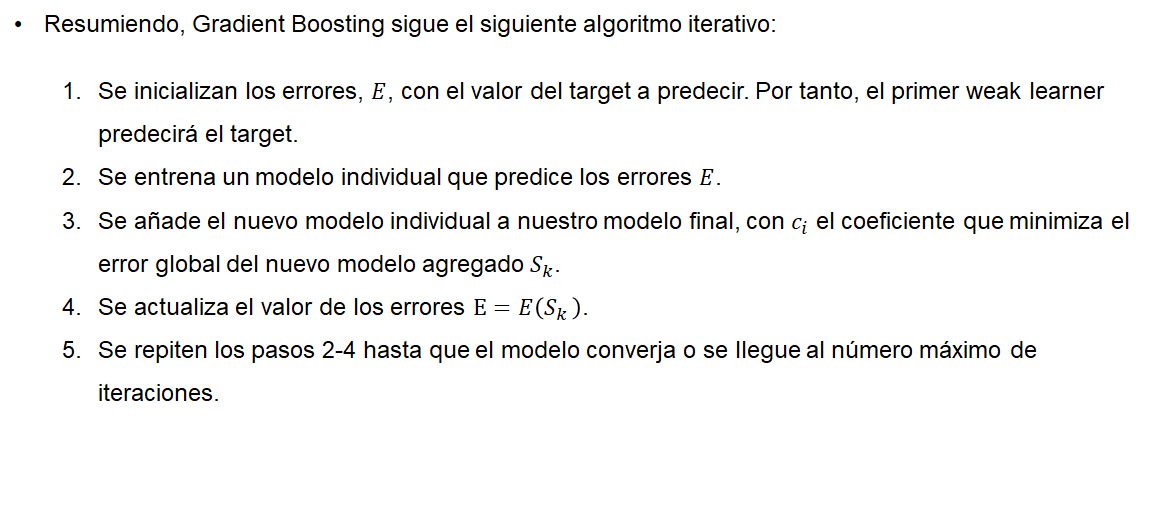


1) Importar modelo.

En este caso tenemos que irnos fuera de scikit-learn para aplicar modelos XGBoost.


In [1]:
from xgboost import XGBClassifier

2) Importar métrica.

In [2]:
from sklearn.metrics import roc_auc_score as auc

3) Definir el método.

Vamos a entrenar un modelo con parámetros por defecto

In [3]:
model = XGBClassifier(random_state = 1)

4) Llamar al método fit para entrenar el modelo. **Utilizaremos early stopping**

In [119]:
model.fit(X_train, 
          np.array(y_train), 
          eval_metric = "auc", 
          eval_set=[(X_val, y_val)],
          early_stopping_rounds = 10,
          verbose=True)

[0]	validation_0-auc:0.65323
[1]	validation_0-auc:0.65235
[2]	validation_0-auc:0.66244
[3]	validation_0-auc:0.66497
[4]	validation_0-auc:0.66120
[5]	validation_0-auc:0.65929
[6]	validation_0-auc:0.66927
[7]	validation_0-auc:0.67623
[8]	validation_0-auc:0.66792
[9]	validation_0-auc:0.66522
[10]	validation_0-auc:0.66175
[11]	validation_0-auc:0.66656
[12]	validation_0-auc:0.66626
[13]	validation_0-auc:0.66698
[14]	validation_0-auc:0.66033
[15]	validation_0-auc:0.65882
[16]	validation_0-auc:0.65711


/Users/galovalle/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/galovalle/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

5) Llamar al método predict para generar las predicciones.

In [120]:
pred_train_p = model.predict_proba(X_train)
pred_val_p = model.predict_proba(X_val)
pred_test_p = model.predict_proba(X_test) 

6) Calcular métrica usando las predicciones obtenidas en el paso anterior.

In [121]:
# Calcular métricas de evaluación
auc_train = auc(y_train, pred_train_p[:,1]);
auc_val = auc(y_val, pred_val_p[:,1]);
auc_test = auc(y_test, pred_test_p[:,1]);
results = pd.DataFrame()
results = results.append(pd.DataFrame(data={'model':['XGBoost (Default)'],'auc_train':[auc_train],'auc_val':[auc_val],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_68227/934495496.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(data={'model':['XGBoost (Default)'],'auc_train':[auc_train],'auc_val':[auc_val],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)


In [122]:
results

,model,auc_train,auc_val,auc_test
0,XGBoost (Default),0.822746,0.67623,0.682563


Vamos a comprobar si XGBoost devuelve probabilidades calibradas.

In [124]:
from sklearn.calibration import calibration_curve

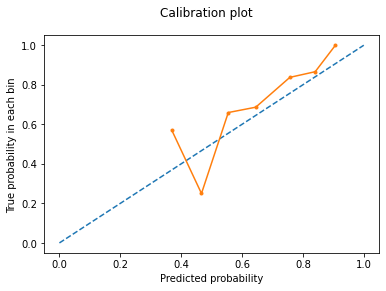

In [125]:
# reliability diagram
fop, mpv = calibration_curve(y_test, pred_test_p[:, 1], n_bins=10)
no_zeros = fop > 0
fop = fop[no_zeros]
mpv = mpv[no_zeros]
no_zeros = mpv > 0
fop = fop[no_zeros]
mpv = mpv[no_zeros]

fig, ax = plt.subplots()
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')

fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.show()

También se puede medir con el brier score.

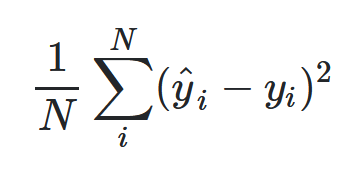

Donde:

- $y_i$ es el target a predecir (0 o 1).
- $\hat{y}_i$ es la probabilidad predicha de pertenecer a la clase 1, $P(y_i = 1)$.

In [79]:
from sklearn.metrics import brier_score_loss

In [82]:
brier_score_loss(y_test, pred_test_p[:, 1])

0.0982403601118961

# Grid Search


Vamos a proceder a calcular los parámetros óptimos para nuestro modelo. En nuestro caso queremos optimizar todos los hiperparámetros que hemos visto en clase:

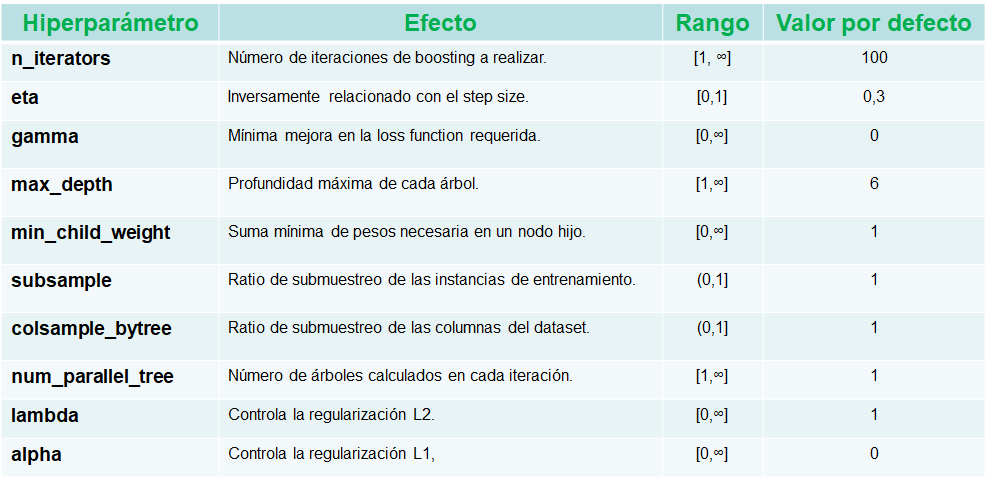

Para establecer nthread detectaremos automáticamente el número de CPUs en nuestro sistema y dejaremos uno libre. Para ello usaremos la función multiprocessing.cpu_count()

In [85]:
nthread = multiprocessing.cpu_count() - 1;
print(nthread);

7


Podemos ayudar a nuestro modelo XGBoost indicando el ratio entre casos negativos y positivos.

In [86]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
print(scale_pos_weight)

0.22058424527448675


XGBoost lleva a cabo computaciones con componente **aleatorio** (por ejemplo, al hacer subsample), por lo que es muy importante que nos aseguremos de controlar la semilla aleatorio que empleamos para poder replicar el modelo que evaluamos en validación en caso de ser elegido como el modelo final.

In [87]:
random_state = 1;

Definimos el grid a llevar a cabo

In [88]:
nrounds_values = [2, 10]
eta_values = [0.3, 0.99]
gamma_values = [0, 1]
max_depth_values = [6, 20]
min_child_weight_values = [1, 20]
subsample_values = [0.1, 1]
colsample_bytree_values = [0.1, 1]
num_parallel_tree_values = [1, 20]
lambda_values = [0, 1]
alpha_values = [0, 1]

params_values = {'nrounds': nrounds_values,
             'eta': eta_values,
             'gamma': gamma_values,
             'max_depth': max_depth_values,
             'min_child_weight': min_child_weight_values,
             'subsample': subsample_values,
             'colsample_bytree': colsample_bytree_values,
             'num_parallel_tree': num_parallel_tree_values,
             'lambda': lambda_values,
             'alpha': alpha_values}

num_iteraciones = len(params_values['nrounds']) * len(params_values['eta']) * len(params_values['gamma']) * len(params_values['max_depth']) * \
len(params_values['min_child_weight']) * len(params_values['subsample']) * len(params_values['colsample_bytree']) * \
len(params_values['num_parallel_tree']) * len(params_values['lambda']) * len(params_values['alpha'])

print('El numero de iteraciones es', num_iteraciones)

El numero de iteraciones es 1024


In [89]:
grid_results = pd.DataFrame();
num_iter = 0
for nrounds in params_values['nrounds']:
    for eta in params_values['eta']:
        for gamma in params_values['gamma']:
            for max_depth in params_values['max_depth']:
                for min_child_weight in params_values['min_child_weight']:
                    for subsample in params_values['subsample']:
                        for colsample_bytree in params_values['colsample_bytree']:
                            for num_parallel_tree in params_values['num_parallel_tree']:
                                for lamda in params_values['lambda']:
                                    for alpha in params_values['alpha']:

                                        # print control iteracion modelo
                                        print('Inicio de iteracion ' + str(num_iter) + 
                                              '. Parametro n_estimators = ' + str(nrounds) + 
                                              ', parametro eta = ' + str(eta) + 
                                              ', parametro gamma = '  + str(gamma) +
                                              ', parametro max_depth = '  + str(max_depth) +
                                              ', parametro min_child_weight = '  + str(min_child_weight) +
                                              ', parametro subsample = '  + str(subsample) +
                                              ', parametro colsample_bytree = '  + str(colsample_bytree) +
                                              ', parametro num_parallel_tree = '  + str(num_parallel_tree) +
                                              ', parametro lambda = '  + str(lamda) +
                                              ', parametro alpha = '  + str(alpha) + 
                                              '\n')
                                        # Entrenar modelo
                                        model = XGBClassifier(nthread = nthread, 
                                                              scale_pos_weight = scale_pos_weight,
                                                              random_state = random_state,
                                                              n_estimators = nrounds,
                                                              learning_rate = eta, 
                                                              gamma = gamma,
                                                              max_depth = max_depth,
                                                              min_child_weight = min_child_weight ,
                                                              subsample = subsample,
                                                              colsample_bytree = colsample_bytree,
                                                              num_parallel_tree = num_parallel_tree,
                                                              reg_lambda = lamda,
                                                              reg_alpha = alpha)
                                        model.fit(X_train, np.array(y_train))

                                        # Generar predicciones
                                        pred_train_p = model.predict_proba(X_train)
                                        pred_val_p = model.predict_proba(X_val)

                                        # Calcular métricas de evaluación
                                        auc_train = auc(y_train, pred_train_p[:, 1])
                                        auc_val = auc(y_val, pred_val_p[:, 1])

                                        num_iter += 1; 

                                        print('Fin de iteracion ' + str(num_iter) + 
                                              '. Parametro nrounds = ' + str(nrounds) + 
                                              ', parametro eta = ' + str(eta) + 
                                              ', parametro gamma = '  + str(gamma) +
                                              ', parametro max_depth = '  + str(max_depth) +
                                              ', parametro min_child_weight = '  + str(min_child_weight) +
                                              ', parametro subsample = '  + str(subsample) +
                                              ', parametro colsample_bytree = '  + str(colsample_bytree) +
                                              ', parametro num_parallel_tree = '  + str(num_parallel_tree) +
                                              ', parametro lambda = '  + str(lamda) +
                                              ', parametro alpha = '  + str(alpha) + 
                                              '. AUC train = '  + str(auc_train) + 
                                              ' -  AUC val = '  + str(auc_val)  + 
                                              '\n')
                                        grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
                                                                                              'eta':[eta],
                                                                                              'gamma':[gamma],
                                                                                              'max_depth':[max_depth],
                                                                                              'min_child_weight':[min_child_weight],
                                                                                              'subsample':[subsample],
                                                                                              'colsample_bytree':[colsample_bytree],
                                                                                              'num_parallel_tree':[num_parallel_tree],
                                                                                              'lamda':[lamda],
                                                                                              'alpha':[alpha],
                                                                                              'auc_train':[auc_train],
                                                                                              'auc_val':[auc_val]},
                                                                                       columns=['nrounds', 'eta', 'gamma', 'max_depth',
                                                                                               'min_child_weight', 'subsample',
                                                                                               'colsample_bytree', 'num_parallel_tree',
                                                                                               'lamda', 'alpha',
                                                                                               'auc_train', 'auc_val']), 
                                                                           ignore_index=True)


Inicio de iteracion 0. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6412814539649422 -  AUC val = 0.6157043980713237

Inicio de iteracion 1. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 2. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 5. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7037516246556152 -  AUC val = 0.6540231805398458

Inicio de iteracion 5. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 6. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6862388651923057 -  AUC val = 0.6541454725249418

Inicio de iteracion 6. P

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 8. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.674748998100454 -  AUC val = 0.6510704875950774

Inicio de iteracion 8. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 9. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7111923072744339 -  AUC val = 0.6230893288390088

Inicio de iteracion 9. Parametr

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 13. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7805741637049182 -  AUC val = 0.6727440139014002

Inicio de iteracion 13. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 14. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7615812438308881 -  AUC val = 0.6736098411558813

Inicio de iteracion 14. Par

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 15. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7676414396413114 -  AUC val = 0.6646245786570759

Inicio de iteracion 15. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 16. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7473743811327956 -  AUC val = 0.6642622180981601

Inicio de iteracion 16. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 17. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6618862643360991 -  AUC val = 0.622328860833226

Inicio de iteracion 17. Parame

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 20. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 21. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.697082485430986 -  AUC val = 0.655796602465256

Inicio de iteracion 21. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 22. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6942549700435957 -  AUC val = 0.6572595908900373

Inicio de iteracion 22. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 23. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6949177364614381 -  AUC val = 0.6559772183201671

Inicio de iteracion 23. Par

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 24. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6921885597620561 -  AUC val = 0.6558891680908979

Inicio de iteracion 24. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 25. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7520252782341517 -  AUC val = 0.6287791045517452

Inicio de iteracion 25. Parametro

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 28. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7553792504552521 -  AUC val = 0.6452746000675804

Inicio de iteracion 28. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 29. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7520252782341517 -  AUC val = 0.6287791045517452

Inicio de iteracion 29. Parametro 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 30. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7483341103647086 -  AUC val = 0.6281164701340395

Inicio de iteracion 30. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 31. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7477912266687106 -  AUC val = 0.628159742682612

Inicio de iteracion 31. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 32. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7553792504552521 -  AUC val = 0.6452746000675804

Inicio de iteracion 32. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 33. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.5875057470842413 -  AUC val = 0.5668730202809028

Inicio de iteracion 33. P

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 37. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6305250295878196 -  AUC val = 0.6287561512868503

Inicio de iteracion 37. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 38. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6296613029438606 -  AUC val = 0.6268077577519948

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 40. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 41. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.638426721157869 -  AUC val = 0.6451929466498393

Inicio de iteracion 41. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 42. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 45. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6671712086570084 -  AUC val = 0.6501470890368435

Inicio de iteracion 45. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 46. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6672674337306818 -  AUC val = 0.6467199031899017

Inicio de iteracion 46. 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 47. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6684163314455791 -  AUC val = 0.6468847151575083

Inicio de iteracion 47. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 48. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6656634600170729 -  AUC val = 0.6468561176471473

Inicio de iteracion 48. 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 51. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6269361124469525 -  AUC val = 0.6278782829753753

Inicio de iteracion 51. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 52. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6253964556467487 -  AUC val = 0.6282643493652482

Inicio de iteracion 52. Par

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 55. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6722142924603706 -  AUC val = 0.6525489036241324

Inicio de iteracion 55. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 56. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6714297336515919 -  AUC val = 0.651565676063959

Inicio de iteracion 56. P

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 59. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7275167519695456 -  AUC val = 0.6623838132070828

Inicio de iteracion 59. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 60. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.726548846387442 -  AUC val = 0.6706921425330019

Inicio de iteracion 60. Parametro 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 61. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7263085247294547 -  AUC val = 0.6631559459868287

Inicio de iteracion 61. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 62. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7272714614638233 -  AUC val = 0.6612421704908312

Inicio de iteracion 62. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 63. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7275167519695456 -  AUC val = 0.6623838132070828

Inicio de iteracion 63. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 64. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.726548846387442 -  AUC val = 0.6706921425330019

Inicio de iteracion 64. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 65. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6431228384817085 -  AUC val = 0.6159004415305086

Inicio de iteracion 65. P

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 69. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7089076014211348 -  AUC val = 0.6466073945636133

Inicio de iteracion 69. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 70. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6894902714967279 -  AUC val = 0.6542997485676787

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 72. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.676355382076024 -  AUC val = 0.6519965201345288

Inicio de iteracion 72. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 73. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7471567159372416 -  AUC val = 0.6312117743475817

Inicio de iteracion 73. P

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 77. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8313673753541371 -  AUC val = 0.6920454519798884

Inicio de iteracion 77. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 78. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7855657606046984 -  AUC val = 0.680265159126331



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 78. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 79. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8003820673098655 -  AUC val = 0.6746495111707144

Inicio de iteracion 79. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 80. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 80. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 81. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6734443974628767 -  AUC val = 0.6133003257858483

Inicio de iteracion 81. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 82. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 85. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7094699340771105 -  AUC val = 0.6355585959224466

Inicio de iteracion 85. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 86. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.704834703678501 -  AUC val = 0.6392059073425613

Inicio de iteracion 86. P

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 88. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7022944729763839 -  AUC val = 0.6386170243989443

Inicio de iteracion 88. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 89. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.950045299946533 -  AUC val = 0.6404329663068649

Inicio de iteracion 89. Paramet

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 91. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 92. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9080276852329887 -  AUC val = 0.6871985502567379

Inicio de iteracion 92. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 93. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 94. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9249555482802726 -  AUC val = 0.6860245471998145

Inicio de iteracion 94. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 95. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.934128819899034 -  AUC val = 0.668042733711272

Inicio de iteracion 95. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 96. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9080276852329887 -  AUC val = 0.6871985502567379

Inicio de iteracion 96. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 97. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.5875057470842413 -  AUC val = 0.5668730202809028

Inicio de iteracion 97

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 102. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6296613029438606 -  AUC val = 0.6268077577519948

Inicio de iteracion 102. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 103. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6303803211677771 -  AUC val = 0.6292908494739939

Inicio de it

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 106. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 107. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.638426721157869 -  AUC val = 0.6451929466498393

Inicio de iteracion 107. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 108. Parametro nrounds = 2, parametro eta = 0.3, parametro ga

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 110. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6672674337306818 -  AUC val = 0.6467199031899017

Inicio de iteracion 110. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 111. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6684163314455791 -  AUC val = 0.6468847151575083

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 113. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6306347706689511 -  AUC val = 0.6135938265500791

Inicio de iteracion 113. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 114. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6298880900539131 -  AUC val = 0.614944306348572

Inicio de iteracion 11

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 118. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6732808889995385 -  AUC val = 0.6403385192660674

Inicio de iteracion 118. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 119. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6738579984153824 -  AUC val = 0.6407110394668221

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 122. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.763545014033843 -  AUC val = 0.6795347937630335

Inicio de iteracion 122. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 123. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7664155433269989 -  AUC val = 0.6955426264706079

Inicio de iteracion 123. Par

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 125. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7664506960706761 -  AUC val = 0.7081458503131051

Inicio de iteracion 125. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 126. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.763545014033843 -  AUC val = 0.6795347937630335

Inicio de iteracion 126. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 127. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7664155433269989 -  AUC val = 0.6955426264706079

Inicio de iteracion 127. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 128. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7610203573320892 -  AUC val = 0.6857092220197819

Inicio de iteracion 128. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 129. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.641223422273112 -  AUC val = 0.6198833974143335

Inicio de iteracion 129

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 134. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6800915106012778 -  AUC val = 0.6571794426044204

Inicio de iteracion 134. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 135. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6859869742769056 -  AUC val = 0.6543934430424138

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 138. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 139. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7120218452795001 -  AUC val = 0.6417454415192203

Inicio de iteracion 139. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 140. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma =

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 141. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7763971982669994 -  AUC val = 0.674381973935627

Inicio de iteracion 141. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 142. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7516634237519005 -  AUC val = 0.6704863157150092

Inicio de iteracion 142. 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 143. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7607552099759036 -  AUC val = 0.6662497450682465

Inicio de iteracion 143. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 144. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7353084614322675 -  AUC val = 0.6632187852530165

Inicio de iteracion 144.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 146. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6632359739533001 -  AUC val = 0.6228093742638963

Inicio de iteracion 146. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 147. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6632699771874266 -  AUC val = 0.6279373594112525

Inicio de iteracion 147. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 150. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6933216239099174 -  AUC val = 0.6564449381277812

Inicio de iteracion 150. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 151. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6942311455311351 -  AUC val = 0.6550376395915974

Inicio de iteracion 151.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 154. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7470779374520705 -  AUC val = 0.6295482270672426

Inicio de iteracion 154. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 155. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7467692755972508 -  AUC val = 0.6284302901819478

Inicio de iteracion 155. Parametr

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 158. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7470779374520705 -  AUC val = 0.6295482270672426

Inicio de iteracion 158. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 159. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7467692755972508 -  AUC val = 0.6284302901819478

Inicio de iteracion 159. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 160. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7543132842922894 -  AUC val = 0.6463417387436813

Inicio de iteracion 160. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 161. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.5867873592365299 -  AUC val = 0.565292631550429

Inicio de iteracion 161

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 166. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6276874281811462 -  AUC val = 0.6281394233989346

Inicio de iteracion 166. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 167. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6298277037215521 -  AUC val = 0.630427976793873

Inicio de iterac

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 171. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.638426721157869 -  AUC val = 0.6451929466498393

Inicio de iteracion 171. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 172. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6293247932931532 -  AUC val = 0.6419602991299583

Inicio de iteracion 172. 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 174. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6658082055180685 -  AUC val = 0.6467120012462495

Inicio de iteracion 174. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 175. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6673991267361348 -  AUC val = 0.6474826288938709

Inicio de iteracion 1

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 176. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6643854649634495 -  AUC val = 0.6457201191763615

Inicio de iteracion 176. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 177. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6245384023886363 -  AUC val = 0.6308351150334854

Inicio de iteracion 177

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 181. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6724253387057701 -  AUC val = 0.6477738719599153

Inicio de iteracion 181. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 182. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.671168238769301 -  AUC val = 0.6501282748852901

Inicio de iteracion 18

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 184. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6711502359665001 -  AUC val = 0.6497723111379025

Inicio de iteracion 184. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 185. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7262453573256 -  AUC val = 0.6629474851876184

Inicio de iteracion 185. Param

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 189. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7262453573256 -  AUC val = 0.6629474851876184

Inicio de iteracion 189. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 190. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.725709556091672 -  AUC val = 0.6658934050378278

Inicio de iteracion 190. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 191. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7266376738109428 -  AUC val = 0.6627845546351673

Inicio de iteracion 191. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 192. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7261541010996616 -  AUC val = 0.6733287577316756

Inicio de iteracion 192. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 193. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6434068785835728 -  AUC val = 0.6176366114358434

Inicio de iteracion 1

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 197. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7027188274053311 -  AUC val = 0.649990179012889

Inicio de iteracion 197. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 198. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6820724307451087 -  AUC val = 0.6585310512520066

Inicio de iterac

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 200. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6696420423551255 -  AUC val = 0.6531535904550541

Inicio de iteracion 200. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 201. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7374014958382377 -  AUC val = 0.6215108215236904

Inicio de iteracion 2

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 205. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8240080112657868 -  AUC val = 0.6916924984967493

Inicio de iteracion 205. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 206. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7705216656037411 -  AUC val = 0.6835139868165477

Inicio de iteracion 206. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 207. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7871170608242214 -  AUC val = 0.6770155788700521

Inicio de iteracion 207. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 208. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7474747778137092 -  AUC val = 0.6682079219619095



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 208. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 209. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6732750487494021 -  AUC val = 0.6138267457463085

Inicio de iteracion 209. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 210. Parametro nrounds = 2, parametro eta = 0.3, parametro gamm

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 213. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7084167052215877 -  AUC val = 0.63449296237847

Inicio de iteracion 213. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 214. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7036055998617325 -  AUC val = 0.6369327815518966

Inicio de iteracion 214

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 216. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7013108079891507 -  AUC val = 0.6381835463471572

Inicio de iteracion 216. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 217. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9443256370702443 -  AUC val = 0.6518730993003393

Inicio de iteracion 217. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 220. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9030211076280972 -  AUC val = 0.6947768905023906

Inicio de iteracion 220. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 221. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9443256370702443 -  AUC val = 0.6518730993003393

Inicio de iteracion 221. Par

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 222. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9162866332470867 -  AUC val = 0.6887766812890251

Inicio de iteracion 222. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 223. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9271490906100162 -  AUC val = 0.6747240152108652

Inicio de iteracion 223. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 224. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9030211076280972 -  AUC val = 0.6947768905023906

Inicio de iteracion 224. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 225. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.5867873592365299 -  AUC val = 0.565292631550429

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 230. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6276874281811462 -  AUC val = 0.6281394233989346

Inicio de iteracion 230. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 231. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6298277037215521 -  AUC val = 0.630427976793873

Inicio de ite

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 235. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.638426721157869 -  AUC val = 0.6451929466498393

Inicio de iteracion 235. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 236. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6293247932931532 -  AUC val = 0.6419602991299583

Inicio de iteracion 23

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 238. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6658082055180685 -  AUC val = 0.6467120012462495

Inicio de iteracion 238. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 239. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6673991267361348 -  AUC val = 0.6474826288938709

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 241. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6298880900539131 -  AUC val = 0.614944306348572

Inicio de iteracion 241. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 242. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6299669983224206 -  AUC val = 0.6134169735254785

Inicio de iteracion 24

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 246. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6729471047988946 -  AUC val = 0.6400841519370674

Inicio de iteracion 246. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 247. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6735989879569593 -  AUC val = 0.6405048363657982

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 250. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7616765604212069 -  AUC val = 0.6853878763112523

Inicio de iteracion 250. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 251. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7625719541992382 -  AUC val = 0.6816355819254704

Inicio de iteracion 251. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 253. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7653508379164464 -  AUC val = 0.7061436483048074

Inicio de iteracion 253. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 254. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7616765604212069 -  AUC val = 0.6853878763112523

Inicio de iteracion 254. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 255. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7625719541992382 -  AUC val = 0.6816355819254704

Inicio de iteracion 255. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 256. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7593391625333454 -  AUC val = 0.6888082890636348

Inicio de iteracion 256. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 257. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6378765510545582 -  AUC val = 0.5983317868100757

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 261. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7058393194043182 -  AUC val = 0.6525007393961562

Inicio de iteracion 261. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 262. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6885711459086193 -  AUC val = 0.6550180728739821

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 264. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6783282556530006 -  AUC val = 0.6507017302246334

Inicio de iteracion 264. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 265. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6860786569338064 -  AUC val = 0.6114433690275417

Inicio de iteracion 2

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 269. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8012480929729258 -  AUC val = 0.6836569743683525

Inicio de iteracion 269. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 270. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7872263198529607 -  AUC val = 0.6829747732330314

Inicio de iteracion 2

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 271. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7918870619474034 -  AUC val = 0.6758991471168818

Inicio de iteracion 271. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 272. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7748882444960834 -  AUC val = 0.6830379887822503

Inicio de iteracion 2

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 274. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 275. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6702417155310197 -  AUC val = 0.6203846064117123

Inicio de iteracion 275. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 276. Parametro nrounds = 2, parametro eta = 0.99, parametro gam

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 278. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 279. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6985255092670308 -  AUC val = 0.6546940931842349

Inicio de iteracion 279. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 280. Parametro nrounds = 2, parametro eta = 0.99, parametro 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 285. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.777836532548196 -  AUC val = 0.6444196850210003

Inicio de iteracion 285. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 286. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7910184591580925 -  AUC val = 0.616715846858827

Inicio de iteracion 286. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 287. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7940239260401106 -  AUC val = 0.6233286448467662

Inicio de iteracion 287. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 288. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7987128496590201 -  AUC val = 0.65277768370702

Inicio de iteracion 288. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 289. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.5872910112839937 -  AUC val = 0.5655304424260622

Inicio de iteracion 2

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 294. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6307650360577043 -  AUC val = 0.6258087263045168

Inicio de iteracion 294. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 295. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6322070957889645 -  AUC val = 0.6292769270018446

Inicio de it

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 299. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6402707384223159 -  AUC val = 0.6234182002081597

Inicio de iteracion 299. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 300. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6278195105366084 -  AUC val = 0.6117948173785566

Inicio de iteracion 3

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 302. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6775031117408941 -  AUC val = 0.6581220315972387

Inicio de iteracion 302. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 303. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.67841061245016 -  AUC val = 0.655652486064358

Inicio de iteracion 3

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 304. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 305. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6273866831098446 -  AUC val = 0.6287930270238948

Inicio de iteracion 305. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 306. Parametro nrounds = 2, parametro eta = 0.99, parametro 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 309. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 310. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6744236127357206 -  AUC val = 0.6523189946921515

Inicio de iteracion 310. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 311. Parametro nrounds = 2, parametro eta = 0.99, paramet

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 312. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 313. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7294235843687911 -  AUC val = 0.6535584709964803

Inicio de iteracion 313. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 314. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 317. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7294235843687911 -  AUC val = 0.6535584709964803

Inicio de iteracion 317. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 318. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7297505456740377 -  AUC val = 0.6433457732503404

Inicio de iteracion 318. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 319. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7372786651806104 -  AUC val = 0.6675926992061181

Inicio de iteracion 319. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 320. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.726640955475305 -  AUC val = 0.6510629619344561

Inicio de iteracion 320. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 321. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6385952911713254 -  AUC val = 0.5989026081682016

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 325. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7114884913884864 -  AUC val = 0.6460256609975865

Inicio de iteracion 325. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 326. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6918185474700908 -  AUC val = 0.6542226105463103

Inicio de it

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 328. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6810580441881112 -  AUC val = 0.6499228243503284

Inicio de iteracion 328. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 329. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7171671241900084 -  AUC val = 0.6112612480405062

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 333. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.854353320597509 -  AUC val = 0.6869377861162097

Inicio de iteracion 333. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 334. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8162111290100872 -  AUC val = 0.6860681960314181

Inicio de iteracion 334. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 335. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8279890594872306 -  AUC val = 0.6760142897243877

Inicio de iteracion 335. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 336. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7913428618775651 -  AUC val = 0.6831136216714944

Inicio de iteracion 336. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 337. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6758825443007075 -  AUC val = 0.6124883070048096

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 341. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.71316825857053 -  AUC val = 0.6348598383337584

Inicio de iteracion 341. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 342. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7085201796216207 -  AUC val = 0.638430011732505

Inicio de iteracion 3

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 344. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7056889561389057 -  AUC val = 0.6386527712868955

Inicio de iteracion 344. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 345. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9581122427847233 -  AUC val = 0.6269451010583337

Inicio de iteracion 345.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 347. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 348. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9382202766587672 -  AUC val = 0.6660465522314712

Inicio de iteracion 348. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 349. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9581122427847233 -  AUC val = 0.6269451010583337

Inicio de iteracion 349. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 350. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9455133585431903 -  AUC val = 0.667477556598612

Inicio de iteracion 350. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 351. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.948558668909471 -  AUC val = 0.655866591109034

Inicio de iteracion 351. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 352. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9382202766587672 -  AUC val = 0.6660465522314712

Inicio de iteracion 352. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 353. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.5872910112839937 -  AUC val = 0.5655304424260622

Inicio de iterac

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 358. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6307650360577043 -  AUC val = 0.6258087263045168

Inicio de iteracion 358. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 359. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6322070957889645 -  AUC val = 0.6292769270018446

Inicio de

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 363. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6402707384223159 -  AUC val = 0.6234182002081597

Inicio de iteracion 363. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 364. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6278195105366084 -  AUC val = 0.6117948173785566

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 366. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6775031117408941 -  AUC val = 0.6581220315972387

Inicio de iteracion 366. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 367. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.67841061245016 -  AUC val = 0.655652486064358

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 369. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6313194704706385 -  AUC val = 0.6097230030095117

Inicio de iteracion 369. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 370. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6301097970733709 -  AUC val = 0.6077986915886444

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 374. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6765934974172931 -  AUC val = 0.6404845170821207

Inicio de iteracion 374. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 375. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6769098350294346 -  AUC val = 0.6415670833624952

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 377. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 378. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7776333660053611 -  AUC val = 0.6473452855875321

Inicio de iteracion 378. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 379. Parametro nrounds = 2, parametro eta = 0.99, parametro gam

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 381. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7710743386713961 -  AUC val = 0.6600549975278205

Inicio de iteracion 381. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 382. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7776333660053611 -  AUC val = 0.6473452855875321

Inicio de iteracion 382. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 383. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7689947275705008 -  AUC val = 0.641964061960269

Inicio de iteracion 383. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 384. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7780485243579035 -  AUC val = 0.6458917042385273

Inicio de iteracion 384. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 385. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6358064697586471 -  AUC val = 0.6006861897354505

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 389. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 390. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6832994209475423 -  AUC val = 0.6587812794676648

Inicio de iteracion 390. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 391. Parametro nrounds = 2, parametro eta = 0.99, para

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 397. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7980994565304249 -  AUC val = 0.6811674858348253

Inicio de iteracion 397. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 398. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7755462089304803 -  AUC val = 0.684652995551582

Inicio de iteracion 39

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 399. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7833673792105561 -  AUC val = 0.6778174380092521

Inicio de iteracion 399. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 400. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7617015344432181 -  AUC val = 0.6809007011658

Inicio de iteracion 400.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 402. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6673663286329888 -  AUC val = 0.6194969547414296

Inicio de iteracion 402. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 403. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6673340682036647 -  AUC val = 0.6227066489964157

Inicio de iteracion 403.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 406. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.696149473025887 -  AUC val = 0.6556013115721332

Inicio de iteracion 406. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 407. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6980839863567306 -  AUC val = 0.6535539556001074

Inicio de iteracion 40

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 410. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7767818760759734 -  AUC val = 0.6452057402728955

Inicio de iteracion 410. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 411. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7931869347634419 -  AUC val = 0.6270877123271072

Inicio de iteracion 411. Param

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 413. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7774322018340016 -  AUC val = 0.6449062189801676

Inicio de iteracion 413. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 414. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7767818760759734 -  AUC val = 0.6452057402728955

Inicio de iteracion 414. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 415. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7931869347634419 -  AUC val = 0.6270877123271072

Inicio de iteracion 415. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 416. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7975165068644446 -  AUC val = 0.6536431346784699

Inicio de iteracion 416. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 417. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.5821914902697911 -  AUC val = 0.5555627049331459

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 422. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.628181643126009 -  AUC val = 0.6268630713575616

Inicio de iteracion 422. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 423. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6316210684038648 -  AUC val = 0.6282022626651225

Inicio de ite

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 427. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6378981321693473 -  AUC val = 0.6158409888116004

Inicio de iteracion 427. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 428. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6235635626682757 -  AUC val = 0.6166040907986006

Inicio de iteracion 4

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 430. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6758322069066761 -  AUC val = 0.6561646072696378

Inicio de iteracion 430. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 431. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6774857763952515 -  AUC val = 0.6558613231465991

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 432. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 433. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6268418712042777 -  AUC val = 0.6270305173063855

Inicio de iteracion 433. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 434. Parametro nrounds = 2, parametro eta = 0.99, parametro 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 437. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 438. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6741095185212501 -  AUC val = 0.6505587426728286

Inicio de iteracion 438. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 439. Parametro nrounds = 2, parametro eta = 0.99, paramet

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 440. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 441. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7294055815659901 -  AUC val = 0.6543441499653443

Inicio de iteracion 441. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 442. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 445. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7294055815659901 -  AUC val = 0.6543441499653443

Inicio de iteracion 445. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 446. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7280339385649442 -  AUC val = 0.6446853408409324

Inicio de iteracion 446. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 447. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7281003505522077 -  AUC val = 0.6450834482877993

Inicio de iteracion 447. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 448. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7264655254854981 -  AUC val = 0.6511118787284946

Inicio de iteracion 448. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 449. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.638713727735993 -  AUC val = 0.5950950001768529

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 453. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7057625989120523 -  AUC val = 0.6503261997596304

Inicio de iteracion 453. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 454. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6854501347762868 -  AUC val = 0.6586450650104192

Inicio de it

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 456. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6722483142349738 -  AUC val = 0.6536073877905187

Inicio de iteracion 456. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 457. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7157255279706637 -  AUC val = 0.6320076129582846

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 461. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8461231103221768 -  AUC val = 0.6918422591431133

Inicio de iteracion 461. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 462. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.795334960223076 -  AUC val = 0.6943151912232735

Inicio de iteracion 462. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 463. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8144631699550241 -  AUC val = 0.6809014537318623

Inicio de iteracion 463. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 464. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7685224830904362 -  AUC val = 0.6833239638858598



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 464. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 465. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6753733301102568 -  AUC val = 0.6089313035121506

Inicio de iteracion 465. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 466. Parametro nrounds = 2, parametro eta = 0.99, parametro 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 469. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7122478907704878 -  AUC val = 0.6355740235267202

Inicio de iteracion 469. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 470. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7073519998110354 -  AUC val = 0.6376714251418776

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 472. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7046575308838916 -  AUC val = 0.6381440366288955

Inicio de iteracion 472. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 473. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9520943192610003 -  AUC val = 0.655796602465256

Inicio de iteracion 473. 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 476. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9289872305433736 -  AUC val = 0.6770961034387001

Inicio de iteracion 476. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 477. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9520943192610003 -  AUC val = 0.655796602465256

Inicio de iteracion 477. P

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 478. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.934538323406206 -  AUC val = 0.6702838754442961

Inicio de iteracion 478. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 479. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9434561443380555 -  AUC val = 0.6658407254134786

Inicio de iteracion 479. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 480. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9289872305433736 -  AUC val = 0.6770961034387001

Inicio de iteracion 480. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 481. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.5821914902697911 -  AUC val = 0.5555627049331459

Inicio de iterac

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 486. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.628181643126009 -  AUC val = 0.6268630713575616

Inicio de iteracion 486. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 487. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6316210684038648 -  AUC val = 0.6282022626651225

Inicio de 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 491. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6378981321693473 -  AUC val = 0.6158409888116004

Inicio de iteracion 491. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 492. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6235635626682757 -  AUC val = 0.6166040907986006

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 494. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6758322069066761 -  AUC val = 0.6561646072696378

Inicio de iteracion 494. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 495. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6774857763952515 -  AUC val = 0.6558613231465991

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 496. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 497. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6309702235124911 -  AUC val = 0.6079492048010705

Inicio de iteracion 497. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 498. Parametro nrounds = 2, parametro eta = 0.99, paramet

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 501. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6768940756243051 -  AUC val = 0.6406828182394921

Inicio de iteracion 501. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 502. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6761211973157988 -  AUC val = 0.6398482224765896

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 504. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6758960232272125 -  AUC val = 0.6397635587945999

Inicio de iteracion 504. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 505. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7700538522975896 -  AUC val = 0.6576155546374249

Inicio de iteracion 5

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 508. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7766921216286414 -  AUC val = 0.647984966740343

Inicio de iteracion 508. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 509. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7700538522975896 -  AUC val = 0.6576155546374249

Inicio de iteracion 509. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 510. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7751266194040253 -  AUC val = 0.6553258723933933

Inicio de iteracion 510. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 511. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7761735815784494 -  AUC val = 0.6618073476034909

Inicio de iteracion 511. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 512. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7766921216286414 -  AUC val = 0.647984966740343

Inicio de iteracion 512. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 513. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7010941996007641 -  AUC val = 0.6250407326381129

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 517. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7189283211453802 -  AUC val = 0.6501982635290683

Inicio de iteracion 517. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 518. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7060384812042024 -  AUC val = 0.6456640530047328

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 519. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7110338603612137 -  AUC val = 0.64557826047365

Inicio de iteracion 519. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 520. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6947896588489264 -  AUC val = 0.6393981879714357

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 521. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7818920949451875 -  AUC val = 0.6460550110740095

Inicio de iteracion 521. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 522. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7786512752529172 -  AUC val = 0.677089330344141

Inicio de iteracion 522. 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 525. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8362045671646008 -  AUC val = 0.6880380376990443

Inicio de iteracion 525. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 526. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8138482008859158 -  AUC val = 0.6936649741455929

Inicio de iteracion 526. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 527. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8200299480610796 -  AUC val = 0.6905192480058882

Inicio de iteracion 527. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 528. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8002560291497823 -  AUC val = 0.6928348937790632

Inicio de iteracion 528. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 529. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6908209771253903 -  AUC val = 0.6459142812203911

Inicio de iteracion 529

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 533. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7274152799409879 -  AUC val = 0.6663961191673309

Inicio de iteracion 533. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 534. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7235441396649656 -  AUC val = 0.6651178857108024

Inicio de iteracion 534. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 535. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7235284915026956 -  AUC val = 0.6642490481920729

Inicio de iteracion 535. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 536. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7222656996399033 -  AUC val = 0.6652307706201219

Inicio de iteracion 536. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 537. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8597401448374618 -  AUC val = 0.6696219935926524

Inicio de iteracion 537. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 538. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 539. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8552754126618773 -  AUC val = 0.6801503928018561

Inicio de iteracion 539. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 540. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 541. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8597401448374618 -  AUC val = 0.6696219935926524

Inicio de iteracion 541. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 542. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8453416106920406 -  AUC val = 0.6730969673845394

Inicio de iteracion 542. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 543. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8552754126618773 -  AUC val = 0.6801503928018561

Inicio de iteracion 543. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 544. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8418536649868623 -  AUC val = 0.6807817957279835

Inicio de iteracion 544. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 545. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6352476968741831 -  AUC val = 0.615792448300593

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 549. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6453207192829818 -  AUC val = 0.6283749765763813

Inicio de iteracion 549. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 550. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6438043493214167 -  AUC val = 0.6285789219792186

Inicio de it

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 551. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6446930314469104 -  AUC val = 0.6284637793717126

Inicio de iteracion 551. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 552. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6428718931306162 -  AUC val = 0.6284788306929553

Inicio de it

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 553. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 554. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6693101492830972 -  AUC val = 0.6359514354068786

Inicio de iteracion 554. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 555. Parametro nrounds = 10, parametro eta = 0.3, parametro 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 557. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6878635486183025 -  AUC val = 0.6674286398045737

Inicio de iteracion 557. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 558. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6854174293755237 -  AUC val = 0.6666290383635601

Inicio de iteracion 558. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 559. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6863840927456938 -  AUC val = 0.6669003384289582

Inicio de iteracion 559. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 560. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6839978777828839 -  AUC val = 0.6655095963461413

Inicio de iteracion 560. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 561. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6625096693220708 -  AUC val = 0.6291964024331965

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 565. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6943748527654401 -  AUC val = 0.6522851292193558

Inicio de iteracion 565. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 566. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6949947906822833 -  AUC val = 0.6525741145872137

Inicio de iteracion 566. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 567. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6936623422488182 -  AUC val = 0.6519769534169133

Inicio de iteracion 567. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 568. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6954251151447031 -  AUC val = 0.652771663178523

Inicio de iteracion 568. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 569. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7936024453850399 -  AUC val = 0.7074903652729896

Inicio de iteracion 569. 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 571. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.795907749707867 -  AUC val = 0.6911841401217802

Inicio de iteracion 571. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 572. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7827636271298049 -  AUC val = 0.6833028920361202

Inicio de iteracion 572. Par

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 573. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7936024453850399 -  AUC val = 0.7074903652729896

Inicio de iteracion 573. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 574. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.798446163443275 -  AUC val = 0.6865701575948591

Inicio de iteracion 574. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 575. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7959076755459605 -  AUC val = 0.6911841401217802

Inicio de iteracion 575. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 576. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7827636271298049 -  AUC val = 0.6833028920361202

Inicio de iteracion 576. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 577. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7010227631443358 -  AUC val = 0.6273522392979461

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 581. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7323156947767362 -  AUC val = 0.6522640573696161

Inicio de iteracion 581. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 582. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7104847841460236 -  AUC val = 0.6468786946290113



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 582. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 583. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.718338437341143 -  AUC val = 0.6465159577870644

Inicio de iteracion 583. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 584. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6965352632634583 -  AUC val = 0.6408352128670736

Inicio de iteracion 584. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 585. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8285904013060209 -  AUC val = 0.6719515618379771

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 587. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8095725630314095 -  AUC val = 0.6788224899852271

Inicio de iteracion 587. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 588. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7899098498988969 -  AUC val = 0.659209865840048

Inicio de iteracion 58

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 589. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8861416723057526 -  AUC val = 0.69155854173769

Inicio de iteracion 589. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 590. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.839859877752255 -  AUC val = 0.6939246094370278

Inicio de iteracion 590. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 591. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8561842297449835 -  AUC val = 0.6857359381149876

Inicio de iteracion 591. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 592. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8184405842430498 -  AUC val = 0.6945206417582351

Inicio de iteracion 592. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 593. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7032112624644379 -  AUC val = 0.6179207051242975

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 596. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6991317643121263 -  AUC val = 0.627813938577063

Inicio de iteracion 596. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 597. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7728765842420113 -  AUC val = 0.6473806561924523

Inicio de iteracion 597. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 598. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7620351146986192 -  AUC val = 0.6501271460361968

Inicio de iteracion 598. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 599. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7637157903640175 -  AUC val = 0.6481866544449939

Inicio de iteracion 599. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 600. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7561580246353246 -  AUC val = 0.6497407033632929

Inicio de iteracion 600. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 601. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9730453730330918 -  AUC val = 0.6612489435853903

Inicio de iteracion 601. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 602. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9604932107926487 -  AUC val = 0.6647325718869916

Inicio de iteracion 602. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 603. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9667419261693747 -  AUC val = 0.6514889143256217

Inicio de iteracion 603. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 604. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9568183400021574 -  AUC val = 0.6701830315919708

Inicio de iteracion 604. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 605. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9730453730330918 -  AUC val = 0.6612489435853903

Inicio de iteracion 605. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 606. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9604932107926487 -  AUC val = 0.6647325718869916

Inicio de iteracion 606. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 607. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9667419261693746 -  AUC val = 0.6514889143256217

Inicio de iteracion 607. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 608. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9568183400021574 -  AUC val = 0.6701995880453377

Inicio de iteracion 608. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 609. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6352476968741831 -  AUC val = 0.615792448300593

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 612. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 613. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6453207192829818 -  AUC val = 0.6283749765763813

Inicio de iteracion 613. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 614. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6438043493214167 -  AUC val = 0.6285789219792186

Inicio de iteracion 614. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 615. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6446930314469104 -  AUC val = 0.6284637793717126

Inicio de

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 616. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6428718931306162 -  AUC val = 0.6284788306929553

Inicio de iteracion 616. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 617. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6724873566000742 -  AUC val = 0.6326841698481397

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 619. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6704231897162057 -  AUC val = 0.6345008643221224

Inicio de iteracion 619. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 620. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6709401538258848 -  AUC val = 0.6349305795435988

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 621. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6878635486183025 -  AUC val = 0.6674286398045737

Inicio de iteracion 621. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 622. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6854174293755237 -  AUC val = 0.6666290383635601

Inicio de iteracion 622. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 623. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6863840927456938 -  AUC val = 0.6669003384289582

Inicio de iteracion 623. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 624. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6839978777828839 -  AUC val = 0.6655095963461413

Inicio de iteracion 624. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 625. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6614933730959811 -  AUC val = 0.6306533703294809

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 629. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7063848543884734 -  AUC val = 0.6516864629169309

Inicio de iteracion 629. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 630. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7045854455107814 -  AUC val = 0.6509109435899056

Inicio de iteracion 630. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 631. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7058096175607682 -  AUC val = 0.651167192334061

Inicio de iteracion 631. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 632. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7046689147365381 -  AUC val = 0.6505798145225683

Inicio de iteracion 632. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 633. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8343161269181654 -  AUC val = 0.7142525476242618

Inicio de iteracion 6

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 634. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8326556603722861 -  AUC val = 0.6977258206168484

Inicio de iteracion 634. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 635. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8356240648415347 -  AUC val = 0.7106123855817372

Inicio de iteracion 635. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 636. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8252166463963636 -  AUC val = 0.7076371156551049

Inicio de iteracion 636.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 637. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8343161269181654 -  AUC val = 0.7142525476242618

Inicio de iteracion 637. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 638. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8326556603722861 -  AUC val = 0.6977258206168484

Inicio de iteracion 638. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 639. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8356240648415347 -  AUC val = 0.710610127883551

Inicio de iteracion 639. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 640. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.82521672055827 -  AUC val = 0.7076371156551049

Inicio de iteracion 640. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 641. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6960966326675114 -  AUC val = 0.620769167669461

Inicio de iteracion 64

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 645. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7146075186898201 -  AUC val = 0.6503615703645504

Inicio de iteracion 645. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 646. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.697417493303087 -  AUC val = 0.6457453301394429



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 646. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 647. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7049091436921423 -  AUC val = 0.645981635882952

Inicio de iteracion 647. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 648. Parametro nrounds = 10, parametro eta = 0.3, param

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 648. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 649. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7798204562492401 -  AUC val = 0.649008080301809

Inicio de iteracion 649. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 650. Parametro nrounds = 10, parametro eta = 0.3, parametro gamm

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 651. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 652. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7537365086050245 -  AUC val = 0.6595421237564787

Inicio de iteracion 652. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 653. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8319544966273577 -  AUC val = 0.6924631261443707

Inicio de iteracion 653. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 654. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8007412519634829 -  AUC val = 0.6939035375872882

Inicio de iteracion 654. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 655. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8120537423154823 -  AUC val = 0.6895981071458406

Inicio de iteracion 655. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 656. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7807918659814254 -  AUC val = 0.6898178564359825

Inicio de iteracion 656. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 657. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6907884942103468 -  AUC val = 0.6428031731195444

Inicio de iteracion 657

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 661. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7258204837633074 -  AUC val = 0.665098318993187

Inicio de iteracion 661. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 662. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7216855310454162 -  AUC val = 0.6635416360936703

Inicio de iteracion 662. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 663. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7220633303375632 -  AUC val = 0.6633531182951067

Inicio de iteracion 663. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 664. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7207047954534895 -  AUC val = 0.6628899138838655

Inicio de iteracion 664. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 665. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.855778434333136 -  AUC val = 0.6764583037010445

Inicio de iteracion 665. Par

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 667. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8494682572764047 -  AUC val = 0.6649146928740273

Inicio de iteracion 667. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 668. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8408920260858573 -  AUC val = 0.6696998841800831

Inicio de iteracion 668. Param

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 669. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.855778434333136 -  AUC val = 0.6764583037010445

Inicio de iteracion 669. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 670. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8424049475187707 -  AUC val = 0.6649286153461766

Inicio de iteracion 670. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 671. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8494682572764047 -  AUC val = 0.6649146928740273

Inicio de iteracion 671. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 672. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8408920260858573 -  AUC val = 0.6696998841800831

Inicio de iteracion 672. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 673. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.635285426744111 -  AUC val = 0.619574092762798

Inicio de iteracion 6

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 677. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6426607356423568 -  AUC val = 0.6273025699378456

Inicio de iteracion 677. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 678. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6409866418461597 -  AUC val = 0.6276905177428738

Inicio de it

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 679. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6418776971526611 -  AUC val = 0.6279268234863826

Inicio de iteracion 679. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 680. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6398271389786341 -  AUC val = 0.6269108593025067

Inicio de it

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 681. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 682. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6695474859243483 -  AUC val = 0.6426921696253802

Inicio de iteracion 682. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 683. Parametro nrounds = 10, parametro eta = 0.3, parametro 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 686. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6842223287928817 -  AUC val = 0.6677383207391403

Inicio de iteracion 686. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 687. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6852831777842966 -  AUC val = 0.6673872486711564

Inicio de iteracion 687. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 688. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6828341106057347 -  AUC val = 0.6692506022409912

Inicio de iteracion 688. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 689. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.661634429042129 -  AUC val = 0.6303749208864926

Inicio de iteracion 6

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 693. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6932260477529258 -  AUC val = 0.6506336229960107

Inicio de iteracion 693. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 694. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6942377644812895 -  AUC val = 0.6519916284551249

Inicio de iteracion 694. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 695. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6929285843459863 -  AUC val = 0.6511890167498627

Inicio de iteracion 695. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 696. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6940123679069836 -  AUC val = 0.6522038520846456

Inicio de iteracion 696. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 697. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8009137340175065 -  AUC val = 0.7068717559699184

Inicio de iteracion 697.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 698. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 699. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7948863177697527 -  AUC val = 0.6860456190495541

Inicio de iteracion 699. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 700. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 701. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8009138452603662 -  AUC val = 0.7068717559699184

Inicio de iteracion 701. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 702. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7977772786681471 -  AUC val = 0.6887296459101421

Inicio de iteracion 702. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 703. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7948858727983138 -  AUC val = 0.6860456190495541

Inicio de iteracion 703. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 704. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7955763016072777 -  AUC val = 0.7176913982451665

Inicio de iteracion 704. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 705. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6968608896543881 -  AUC val = 0.626560539800585

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 707. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6974421706774724 -  AUC val = 0.6500229156365919

Inicio de iteracion 707. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 708. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6736411119198467 -  AUC val = 0.6515604081015242

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 709. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7253127528109865 -  AUC val = 0.6543170575871077

Inicio de iteracion 709. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 710. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7011788368765483 -  AUC val = 0.6464075882741176

Inicio de iteracion 710. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 711. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7103765077625452 -  AUC val = 0.6480331309683192

Inicio de iteracion 711. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 712. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6880638599277373 -  AUC val = 0.6416122373262231

Inicio de iteracion 712. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 713. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8213076835480302 -  AUC val = 0.665548729781372

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 714. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 715. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7985045844851142 -  AUC val = 0.6867519022988635

Inicio de iteracion 715. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 716. Parametro nrounds = 10, parametro eta = 0.3, parametro 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 716. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 717. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8753102146197369 -  AUC val = 0.6964457057451646

Inicio de iteracion 717. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 718. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8181563401959424 -  AUC val = 0.6965969715236527

Inicio de iteracion 718. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 719. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8401766974167888 -  AUC val = 0.6914245849786307

Inicio de iteracion 719. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 720. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7939502091050575 -  AUC val = 0.6923412104423057

Inicio de iteracion 720. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 721. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.703253553291615 -  AUC val = 0.6175621073956924

Inicio de iteracion 7

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 724. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 725. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7704967842841131 -  AUC val = 0.647454783949572

Inicio de iteracion 725. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 726. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7594425256905187 -  AUC val = 0.6485256854559835

Inicio de iteracion 726. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 727. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7614076864292203 -  AUC val = 0.6469953423686414

Inicio de iteracion 727. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 728. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7535409621980818 -  AUC val = 0.6480368937986298

Inicio de iteracion 728. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 729. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9686151632249795 -  AUC val = 0.6526862469304712

Inicio de iteracion 729. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 730. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9555489662701638 -  AUC val = 0.6660853093836709



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 730. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 731. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.960074974720987 -  AUC val = 0.6732128625581075

Inicio de iteracion 731. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 732. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9449790961688218 -  AUC val = 0.6738517911448562

Inicio de iteracion 732. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 733. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9686151632249795 -  AUC val = 0.6526862469304712

Inicio de iteracion 733. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 734. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9555489662701637 -  AUC val = 0.6660853093836709

Inicio de iteracion 734. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 735. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9600750488828935 -  AUC val = 0.6732128625581075

Inicio de iteracion 735. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 736. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9449791703307283 -  AUC val = 0.673851038578794

Inicio de iteracion 736. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 737. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.635285426744111 -  AUC val = 0.619574092762798

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 741. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6426607356423568 -  AUC val = 0.6273025699378456

Inicio de iteracion 741. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 742. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6409866418461597 -  AUC val = 0.6276905177428738

Inicio de

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 743. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6418776971526611 -  AUC val = 0.6279268234863826

Inicio de iteracion 743. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 744. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6398271389786341 -  AUC val = 0.6269108593025067

Inicio de

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 745. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6724873566000742 -  AUC val = 0.6326841698481397

Inicio de iteracion 745. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 746. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6695474859243483 -  AUC val = 0.6426921696253802

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 749. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6866268802870718 -  AUC val = 0.66691162691989

Inicio de iteracion 749. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 750. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6842223287928817 -  AUC val = 0.6677383207391403

Inicio de iteracion 750. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 751. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6852831777842966 -  AUC val = 0.6673872486711564

Inicio de iteracion 751. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 752. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6828341106057347 -  AUC val = 0.6692506022409912

Inicio de iteracion 752. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 753. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6620293226537222 -  AUC val = 0.6273977695447052

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 756. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 757. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7054625583788623 -  AUC val = 0.6511566564091913

Inicio de iteracion 757. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 758. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7039765020965756 -  AUC val = 0.6511047293509041

Inicio de iteracion 758. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 759. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7049050462468086 -  AUC val = 0.6512552425633302

Inicio de iteracion 759. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 760. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7039087366545186 -  AUC val = 0.650439460951981

Inicio de iteracion 760. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 761. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.836934616972108 -  AUC val = 0.7217499870182355

Inicio de iteracion 761

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 762. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8316060654501815 -  AUC val = 0.7110627963699224

Inicio de iteracion 762. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 763. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.832587004987351 -  AUC val = 0.7163574749000405

Inicio de iteracion 763. 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 764. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8315780693304807 -  AUC val = 0.7048262814130483

Inicio de iteracion 764. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 765. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.836934616972108 -  AUC val = 0.7217499870182355

Inicio de iteracion 765. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 766. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8316060654501815 -  AUC val = 0.7110627963699224

Inicio de iteracion 766. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 767. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8325869864468743 -  AUC val = 0.7163574749000405

Inicio de iteracion 767. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 768. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8315780693304807 -  AUC val = 0.7048262814130483

Inicio de iteracion 768. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 769. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6755717502910762 -  AUC val = 0.632287567533397

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 772. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 773. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7459831593884357 -  AUC val = 0.6567854742708952

Inicio de iteracion 773. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 774. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7301188707826303 -  AUC val = 0.6568050409885106

Inicio de iteracion 774. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 775. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7348471743738871 -  AUC val = 0.6562135240636762

Inicio de iteracion 775. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 776. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7182051127737469 -  AUC val = 0.6510433952168406

Inicio de iteracion 776. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 777. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7354703568741394 -  AUC val = 0.6077298317939595

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 779. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7605026330628686 -  AUC val = 0.6074242899727345

Inicio de iteracion 779. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 780. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.767250346827426 -  AUC val = 0.6455157974904931

Inicio de iteracion 78

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 781. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8829226191330376 -  AUC val = 0.6721769553735851

Inicio de iteracion 781. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 782. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8600834773835666 -  AUC val = 0.6967173820935937

Inicio de iteracion 782. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 783. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8681123566232497 -  AUC val = 0.68335933449078

Inicio de iteracion 783. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 784. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8476135977783764 -  AUC val = 0.6965999817879013

Inicio de iteracion 784. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 785. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7001775584365231 -  AUC val = 0.6443440521317563

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 788. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 789. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7597040761942393 -  AUC val = 0.6674365417482261

Inicio de iteracion 789. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 790. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.754723065906611 -  AUC val = 0.6694831451541895

Inicio de iteracion 790. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 791. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7533742091513345 -  AUC val = 0.6649918308953956

Inicio de iteracion 791. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 792. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7513053886078339 -  AUC val = 0.6676638166989893

Inicio de iteracion 792. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 793. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9072993782302842 -  AUC val = 0.6564697728078316

Inicio de iteracion 793.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 794. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9129061666848919 -  AUC val = 0.6421785432879761

Inicio de iteracion 794. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 795. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9108726472088814 -  AUC val = 0.6624203126610962

Inicio de iteracion 795. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 796. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9181752403578118 -  AUC val = 0.6732813460697614

Inicio de iteracion 796. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 797. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9072993782302842 -  AUC val = 0.6564697728078316

Inicio de iteracion 797. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 798. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9129061666848919 -  AUC val = 0.6421785432879761

Inicio de iteracion 798. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 799. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9108726472088814 -  AUC val = 0.6624203126610962

Inicio de iteracion 799. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 800. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.918175277438765 -  AUC val = 0.6732813460697614

Inicio de iteracion 800. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 801. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6351607605792979 -  AUC val = 0.630943108263401

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 804. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6320602552141105 -  AUC val = 0.6337678649776073

Inicio de iteracion 804. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 805. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6560367068805897 -  AUC val = 0.6329234858558971

Inicio de iteracion 805. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 806. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.653473634311273 -  AUC val = 0.6327278186797433

Inicio de 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 807. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6549331591715122 -  AUC val = 0.6323613190074857

Inicio de iteracion 807. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 808. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6532271386745703 -  AUC val = 0.6337102936738545

Inicio de

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 809. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6724525190444994 -  AUC val = 0.6488997107888623

Inicio de iteracion 809. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 810. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6697765905939786 -  AUC val = 0.6169664513575163

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 813. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.716687055628809 -  AUC val = 0.6722811857731901

Inicio de iteracion 813. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 814. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7142867499037656 -  AUC val = 0.6717630440394133

Inicio de iteracion 814. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 815. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7159920287816426 -  AUC val = 0.6693932135097649

Inicio de iteracion 815. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 816. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7130022286023711 -  AUC val = 0.6682297463777114

Inicio de iteracion 816. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 817. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6703250735139168 -  AUC val = 0.6128356162424828

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 821. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7216013572815478 -  AUC val = 0.6778945760306203

Inicio de iteracion 821. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 822. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7195559162790688 -  AUC val = 0.6773820785423096

Inicio de iteracion 822. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 823. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7213941674552858 -  AUC val = 0.678498134012449

Inicio de iteracion 823. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 824. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7190312022501613 -  AUC val = 0.6770310064743258

Inicio de iteracion 824. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 825. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8245284239041178 -  AUC val = 0.6935027961592037

Inicio de iteracion 8

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 827. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8331201178521689 -  AUC val = 0.6639487743332829

Inicio de iteracion 827. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 828. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8356522092850485 -  AUC val = 0.6862713888681933

Inicio de iteracion 828.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 829. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8245279789326789 -  AUC val = 0.6935027961592037

Inicio de iteracion 829. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 830. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.839395679839045 -  AUC val = 0.6849698258637389

Inicio de iteracion 830. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 831. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8331201178521689 -  AUC val = 0.6639487743332829

Inicio de iteracion 831. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 832. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8356522092850485 -  AUC val = 0.6862713888681933

Inicio de iteracion 832. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 833. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6752270272092248 -  AUC val = 0.6458706323887877

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 835. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 836. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6839562729533418 -  AUC val = 0.6325242495599369

Inicio de iteracion 836. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 837. Parametro nrounds = 10, parametro eta = 0.99,

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 838. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7333676628798484 -  AUC val = 0.6561096699471021

Inicio de iteracion 838. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 839. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7442969030395739 -  AUC val = 0.6556385635922084

Inicio de iteracion 839. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 840. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7211504899710297 -  AUC val = 0.6506129274293021

Inicio de iteracion 840. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 841. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7061445512709628 -  AUC val = 0.5855261226968657

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 843. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7708954972338907 -  AUC val = 0.651109621030308

Inicio de iteracion 843. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 844. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7793523277549861 -  AUC val = 0.669711172671015

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 845. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9213123260833764 -  AUC val = 0.6705062587156558

Inicio de iteracion 845. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 846. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8851979805861186 -  AUC val = 0.6869475694750174

Inicio de iteracion 846. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 847. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9007863127378674 -  AUC val = 0.6769572550002371

Inicio de iteracion 847. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 848. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8667902537757401 -  AUC val = 0.6882713331783048

Inicio de iteracion 848. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 849. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7093696857200099 -  AUC val = 0.6139652179017404

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 852. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7083161231359081 -  AUC val = 0.6201618468573218

Inicio de iteracion 852. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 853. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8106188762891517 -  AUC val = 0.6467921495318663

Inicio de iteracion 853. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 854. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7969162218528218 -  AUC val = 0.6501252646210416

Inicio de iteracion 854. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 855. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8007838579787624 -  AUC val = 0.6490897337195503

Inicio de iteracion 855. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 856. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7898545992785604 -  AUC val = 0.6486916262726833

Inicio de iteracion 856. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 857. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9836297974085827 -  AUC val = 0.6351841943065366



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 857. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 858. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9764537430126042 -  AUC val = 0.6592794782007952

Inicio de iteracion 858. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 859. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9815856913204205 -  AUC val = 0.6449171311880685

Inicio de iteracion 859. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 860. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9743229231152762 -  AUC val = 0.6437468909614559

Inicio de iteracion 860.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 861. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9836297974085828 -  AUC val = 0.6351841943065366

Inicio de iteracion 861. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 862. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9764537430126042 -  AUC val = 0.6592794782007952

Inicio de iteracion 862. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 863. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9815856913204204 -  AUC val = 0.6449171311880685

Inicio de iteracion 863. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 864. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9743229231152762 -  AUC val = 0.6437468909614559

Inicio de iteracion 864. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 865. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6351607605792979 -  AUC val = 0.630943108263401

Inicio de iter

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 869. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6560367068805897 -  AUC val = 0.6329234858558971

Inicio de iteracion 869. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 870. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.653473634311273 -  AUC val = 0.6327278186797433

Inicio 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 871. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6549331591715122 -  AUC val = 0.6323613190074857

Inicio de iteracion 871. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 872. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6532271386745703 -  AUC val = 0.6337102936738545

Inicio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 873. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6724525190444994 -  AUC val = 0.6488997107888623

Inicio de iteracion 873. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 874. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6697765905939786 -  AUC val = 0.6169664513575163

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 876. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 877. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.716687055628809 -  AUC val = 0.6722811857731901

Inicio de iteracion 877. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 878. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7142867499037656 -  AUC val = 0.6717630440394133

Inicio de iteracion 878. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 879. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7159920287816426 -  AUC val = 0.6693932135097649

Inicio de iteracion 879. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 880. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7130022286023711 -  AUC val = 0.6682297463777114

Inicio de iteracion 880. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 881. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6758080301251598 -  AUC val = 0.6198322229221087

Inicio de iter

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 884. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6747490351814074 -  AUC val = 0.6210348234893929

Inicio de iteracion 884. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 885. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7375923515045949 -  AUC val = 0.6608041770426712

Inicio de iteracion 885. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 886. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7350273507257095 -  AUC val = 0.6616237214843312

Inicio de iteracion 886. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 887. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7366671631806307 -  AUC val = 0.6601005277745794

Inicio de iteracion 887. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 888. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7341613806840791 -  AUC val = 0.6616011445024672

Inicio de iteracion 888. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 889. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.868329910575944 -  AUC val = 0.6861430763546001

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 890. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8700231937654458 -  AUC val = 0.6701119140990994

Inicio de iteracion 890. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 891. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8652999146433538 -  AUC val = 0.6767988398441586

Inicio de iteracion 8

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 892. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8702718957188668 -  AUC val = 0.6607022043412527

Inicio de iteracion 892. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 893. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8683298364140374 -  AUC val = 0.6861430763546001

Inicio de iteracion 893. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 894. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8700231937654458 -  AUC val = 0.6701119140990994

Inicio de iteracion 894. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 895. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8652999146433538 -  AUC val = 0.6767988398441586

Inicio de iteracion 895. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 896. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8702718957188668 -  AUC val = 0.6607022043412527

Inicio de iteracion 896. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 897. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6803478883120205 -  AUC val = 0.6516774321241854

Inicio de iterac

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 900. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 901. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.738917569152177 -  AUC val = 0.6550775255928905



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 901. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 902. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7180924793782621 -  AUC val = 0.6588207891859267

Inicio de iteracion 902. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 903. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7256712329264923 -  AUC val = 0.6550707524983312

Inicio de iteracion 903. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 904. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7067356216657038 -  AUC val = 0.6544532720443532



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 904. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 905. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7460803114859403 -  AUC val = 0.6245079158661245

Inicio de iteracion 905. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 906. Parametro nrounds = 10, parametro eta = 0.99, parametro

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 909. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8788223000254785 -  AUC val = 0.6738897957309937

Inicio de iteracion 909. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 910. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8415125387574757 -  AUC val = 0.692556444336075

Inicio de iteracion 910. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 911. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8567015832046716 -  AUC val = 0.6921869343995689

Inicio de iteracion 911. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 912. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8256474899921289 -  AUC val = 0.6957984989317325

Inicio de iteracion 912. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 913. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6985014993498041 -  AUC val = 0.6240228870390816

Inicio de iteracion 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Inicio de iteracion 916. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 917. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7597250825542532 -  AUC val = 0.6644710551804014

Inicio de iteracion 917. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 918. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7534516341817121 -  AUC val = 0.6637798232523346

Inicio de iteracion 918. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 919. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7553574653952201 -  AUC val = 0.6669665642424256

Inicio de iteracion 919. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 920. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7503283611112316 -  AUC val = 0.6649274864970833

Inicio de iteracion 920. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 921. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.909159822357019 -  AUC val = 0.649579277942966

Inicio de iteracion 921. P

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 922. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9053506814348238 -  AUC val = 0.6412912679007244

Inicio de iteracion 922. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 923. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9142784400621433 -  AUC val = 0.6684920156503639

Inicio de iteracion 923. Pa

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 924. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.912293292689642 -  AUC val = 0.6715681294293216

Inicio de iteracion 924. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 925. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.909159822357019 -  AUC val = 0.649579277942966

Inicio de iteracion 925. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 926. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9053507185157771 -  AUC val = 0.6412912679007244

Inicio de iteracion 926. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 927. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9142784400621433 -  AUC val = 0.6684920156503639

Inicio de iteracion 927. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 928. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.912293292689642 -  AUC val = 0.6715681294293216

Inicio de iteracion 928. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 929. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6377091120101759 -  AUC val = 0.6317400757231971

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 933. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6545016851995417 -  AUC val = 0.6339082185481946

Inicio de iteracion 933. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 934. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6502201329329926 -  AUC val = 0.6349223013169154

Inicio de

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 935. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.653135975151015 -  AUC val = 0.633384808851983

Inicio de iteracion 935. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 936. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6500282946213743 -  AUC val = 0.6347951176524154

Inicio de i

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 937. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6712881585720986 -  AUC val = 0.6393127717233839

Inicio de iteracion 937. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 938. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.644800603292277 -  AUC val = 0.6238595802035992

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 941. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7153044737465554 -  AUC val = 0.6741264777575338

Inicio de iteracion 941. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 942. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7101312357972996 -  AUC val = 0.6727981986578737

Inicio de iteracion 942. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 943. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7134821302992806 -  AUC val = 0.6707982543477623

Inicio de iteracion 943. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 944. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7094788520463662 -  AUC val = 0.6693326319417635

Inicio de iteracion 944. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 945. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6706740238244383 -  AUC val = 0.6138760388233779

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 949. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7205764026528753 -  AUC val = 0.6771280874963407

Inicio de iteracion 949. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 950. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7188861601015395 -  AUC val = 0.6744978691091951

Inicio de iteracion 950. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 951. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7202177371326033 -  AUC val = 0.6765963995734455

Inicio de iteracion 951. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 952. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7188166333142032 -  AUC val = 0.6767668557865181

Inicio de iteracion 952. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 953. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8326766111108701 -  AUC val = 0.6703358025025832

Inicio de iteracion 9

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 955. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8307890237263591 -  AUC val = 0.6841487762899547

Inicio de iteracion 955. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 956. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367592796846843 -  AUC val = 0.6653835415307344

Inicio de iteracion 956.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 957. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8326759621941883 -  AUC val = 0.6703358025025832

Inicio de iteracion 957. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 958. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.827364801639334 -  AUC val = 0.6969924449893024

Inicio de iteracion 958. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 959. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8307890237263591 -  AUC val = 0.6841487762899547

Inicio de iteracion 959. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 960. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367591313608713 -  AUC val = 0.6653835415307344

Inicio de iteracion 960. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 961. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6706013451560762 -  AUC val = 0.633378788323486

Inicio de iterac

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 965. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7529588283130728 -  AUC val = 0.6638648632173554

Inicio de iteracion 965. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 966. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7199983476727234 -  AUC val = 0.6589968896444651



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 966. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 967. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7338987919136675 -  AUC val = 0.6573897848187858

Inicio de iteracion 967. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 968. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7091484422124678 -  AUC val = 0.6539799079912733

Inicio de iteracion 968. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 969. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7304622589501648 -  AUC val = 0.5940011454055466

Inicio de itera

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 970. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7694430919166747 -  AUC val = 0.6109018977458389

Inicio de iteracion 970. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 971. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7730071091974374 -  AUC val = 0.606342099975391

Inicio de iteracion

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 972. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 973. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9139461947210591 -  AUC val = 0.6879417092430916

Inicio de iteracion 973. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 974. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8560500708561395 -  AUC val = 0.689052496750796

Inicio de iteracion 974. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 975. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8830047905254308 -  AUC val = 0.6828656511540224

Inicio de iteracion 975. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 976. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8325932345874966 -  AUC val = 0.6963471195910256

Inicio de iteracion 976. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 977. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7092493024052967 -  AUC val = 0.6148129835707303

Inicio de iteraci

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 981. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8071948581473695 -  AUC val = 0.6501877276041984

Inicio de iteracion 981. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 982. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7938464380573986 -  AUC val = 0.6507024827906955

Inicio de iteracion 982. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 983. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7973552417987778 -  AUC val = 0.6484425269061183

Inicio de iteracion 983. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 984. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7858474831469848 -  AUC val = 0.6512638970730449

Inicio de iteracion 984. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 985. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9783617063809238 -  AUC val = 0.6443222277159545



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 985. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 986. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9666403243574807 -  AUC val = 0.6486886160084349

Inicio de iteracion 986. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 987. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9733744850336268 -  AUC val = 0.6671524480597718

Inicio de iteracion 987. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 988. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9622639004720516 -  AUC val = 0.6692411951652147

Inicio de iteracion 988.

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 989. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.978361706380924 -  AUC val = 0.6443222277159545

Inicio de iteracion 989. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 990. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9666403243574806 -  AUC val = 0.6486886160084349

Inicio de iteracion 990. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 991. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9733744479526736 -  AUC val = 0.6671524480597718

Inicio de iteracion 991. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 992. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9622639004720516 -  AUC val = 0.6692411951652147

Inicio de iteracion 992. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 993. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6377091120101759 -  AUC val = 0.6317400757231971

Inicio de ite

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 997. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6545016851995417 -  AUC val = 0.6339082185481946

Inicio de iteracion 997. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 998. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6502201329329926 -  AUC val = 0.6349223013169154

Inicio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 999. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.653135975151015 -  AUC val = 0.633384808851983

Inicio de iteracion 999. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1000. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6500282946213743 -  AUC val = 0.6347951176524154

Inicio 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Inicio de iteracion 1001. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 1002. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.644800603292277 -  AUC val = 0.6238595802035992

Inicio de iteracion 1002. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1003. Parametro nrounds = 10, parametro eta = 0.99, 

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1005. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7153044737465554 -  AUC val = 0.6741264777575338

Inicio de iteracion 1005. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1006. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7101312357972996 -  AUC val = 0.6727981986578737

Inicio de iteracion 1006. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1007. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7134821302992806 -  AUC val = 0.6707982543477623

Inicio de iteracion 1007. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1008. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7094788520463662 -  AUC val = 0.6693326319417635

Inicio de iteracion 1008. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1009. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6745310362572741 -  AUC val = 0.6252111888511853

Inicio de i

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method

Fin de iteracion 1013. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7359045562961735 -  AUC val = 0.6609385100847615

Inicio de iteracion 1013. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1014. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7341884683204253 -  AUC val = 0.6609023869137792

Inicio de iteracion 1014. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1015. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.734993588517779 -  AUC val = 0.6614246677608977

Inicio de iteracion 1015. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1016. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7323885959308177 -  AUC val = 0.661426172893022

Inicio de iteracion 1016. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1017. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8652091219293309 -  AUC val = 0.7011033371036893

Inicio de iterac

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1018. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8659483492727664 -  AUC val = 0.6786757396031117

Inicio de iteracion 1018. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1019. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8654212806033279 -  AUC val = 0.7033241595530361

Inicio de iteracio

/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],
/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1020. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8667818178588768 -  AUC val = 0.6486302921386197

Inicio de iteracion 1020. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1021. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8652091219293309 -  AUC val = 0.7011033371036893

Inicio de iteracion 1021. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1022. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8659487942442055 -  AUC val = 0.6786757396031117

Inicio de iteracion 1022. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1023. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.865421280603328 -  AUC val = 0.7033241595530361

Inicio de iteracion 1023. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


Fin de iteracion 1024. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8667818178588768 -  AUC val = 0.6486302921386197



/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/2779038106.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'nrounds':[nrounds],


In [90]:
grid_results

,nrounds,eta,gamma,max_depth,min_child_weight,subsample,colsample_bytree,num_parallel_tree,lamda,alpha,auc_train,auc_val
0,2,0.30,0,6,1,0.1,0.1,1,0,0,0.641281,0.615704
1,2,0.30,0,6,1,0.1,0.1,1,0,1,0.632007,0.608456
2,2,0.30,0,6,1,0.1,0.1,1,1,0,0.636599,0.618320
3,2,0.30,0,6,1,0.1,0.1,1,1,1,0.620143,0.618493
4,2,0.30,0,6,1,0.1,0.1,20,0,0,0.703752,0.654023
...,...,...,...,...,...,...,...,...,...,...,...,...
1019,10,0.99,1,20,20,1.0,1.0,1,1,1,0.866782,0.648630
1020,10,0.99,1,20,20,1.0,1.0,20,0,0,0.865209,0.701103
1021,10,0.99,1,20,20,1.0,1.0,20,0,1,0.865949,0.678676
1022,10,0.99,1,20,20,1.0,1.0,20,1,0,0.865421,0.703324


Comparemos el peor y el mejor resultado

In [91]:
print(grid_results.iloc[grid_results['auc_val'].idxmin()])
print('-------------------------------------------')
print(grid_results.iloc[grid_results['auc_val'].idxmax()])

nrounds               2.000000
eta                   0.990000
gamma                 1.000000
max_depth             6.000000
min_child_weight     20.000000
subsample             0.100000
colsample_bytree      0.100000
num_parallel_tree     1.000000
lamda                 0.000000
alpha                 0.000000
auc_train             0.582191
auc_val               0.555563
Name: 416, dtype: float64
-------------------------------------------
nrounds              10.000000
eta                   0.300000
gamma                 1.000000
max_depth            20.000000
min_child_weight     20.000000
subsample             1.000000
colsample_bytree      1.000000
num_parallel_tree     1.000000
lamda                 0.000000
alpha                 0.000000
auc_train             0.836935
auc_val               0.721750
Name: 760, dtype: float64


Veamos la mayor diferencia entre auc_train y auc_val.

In [92]:
diff = grid_results['auc_train'] - grid_results['auc_val']
grid_results.iloc[diff.idxmax()]

nrounds              10.000000
eta                   0.990000
gamma                 0.000000
max_depth            20.000000
min_child_weight      1.000000
subsample             1.000000
colsample_bytree      1.000000
num_parallel_tree    20.000000
lamda                 0.000000
alpha                 0.000000
auc_train             0.983630
auc_val               0.635184
Name: 860, dtype: float64

Nos quedamos con el mejor resultado.

In [93]:
best_params = grid_results.iloc[grid_results['auc_val'].idxmax()]

Entrenamos el modelo final.

In [94]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))

# Combinar train y validación
X_train = pd.concat((X_train,X_val), axis = 0)
y_train = np.concatenate((y_train, y_val), axis = 0)

del X_val, y_val

print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))

Train data size = (13496, 24)
Train target size = (13496,)
Validation data size = (2892, 24)
Validation target size = (2892,)
Train data size = (16388, 24)
Train target size = (16388,)


Y ahora entrenamos el modelo final.

Fíjate que debemos pasar los hiperparámetros max_depth y num_parallel_tree como int() ya que la función espera números **enteros**.

In [95]:
model = XGBClassifier(nthread = nthread, 
                      scale_pos_weight = scale_pos_weight,
                      random_state = random_state,
                      n_iterators = best_params['nrounds'], 
                      learning_rate = best_params['eta'], 
                      gamma = best_params['gamma'],
                      max_depth = int(best_params['max_depth']),
                      min_child_weight = best_params['min_child_weight'] ,
                      subsample = best_params['subsample'],
                      colsample_bytree = best_params['colsample_bytree'],
                      num_parallel_tree = int(best_params['num_parallel_tree']),
                      reg_lambda = best_params['lamda'],
                      reg_alpha = best_params['alpha'])
model.fit(X_train, np.array(y_train))
    
# Generar predicciones
pred_train_p = model.predict_proba(X_train)
pred_test_p = model.predict_proba(X_test)
    
# Calcular métricas de evaluación
auc_train = auc(y_train, pred_train_p[:, 1])
auc_test = auc(y_test, pred_test_p[:, 1])

results = results.append(pd.DataFrame(data={'model':['XGBoost (Optimized)'],'auc_train':[auc_train],'auc_val':[None],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)
results

[19:20:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "n_iterators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/var/folders/rl/r629y61j6b995dqxs1hm45zh0000gn/T/ipykernel_58907/3041913620.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(data={'model':['XGBoost (Optimized)'],'auc_train':[auc_train],'auc_val':[None],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)


,model,auc_train,auc_val,auc_test
0,XGBoost (Default),0.851243,0.673127,0.780216
1,XGBoost (Optimized),0.925560,None,0.751813


El mejor modelo entre todos los probados es...

In [96]:
results['model'][results['auc_test'].idxmax()]

'XGBoost (Default)'